In [7]:
import numpy as np
from matplotlib import pyplot as plt

series1 = np.genfromtxt('dane/series1.csv', delimiter=',', skip_header=1)
series2 = np.genfromtxt('dane/series2.csv', delimiter=',', skip_header=1)
series3 = np.genfromtxt('dane/series3.csv', delimiter=',', skip_header=1)

In [305]:
def plot_series(dataset_name, data, window_size):
    mean, std = [], []
    for i in range(len(data) - window_size):
        window_data = data[i:i + window_size]
        mean.append(np.mean(window_data))
        std.append(np.std(window_data))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(f'Dataset: {dataset_name}. Window size: {window_size}', fontsize=16)
    axes[0].plot(range(len(data)-window_size), mean)
    axes[0].set_title('MEAN')
    axes[1].plot(range(len(data)-window_size), std)
    axes[1].set_title('STD')
    fig.tight_layout()

    # plt.figure(figsize=(15,5))
    # plt.title(f'Dataset: {dataset_name}. Window size: {window_size}')
    # plt.xlabel('mean')
    # plt.plot(range(len(data)-window_size), mean)

Niżej są przedstawione wykresy zmian sredniej i standart diviation dla 3 zbiorów danych.

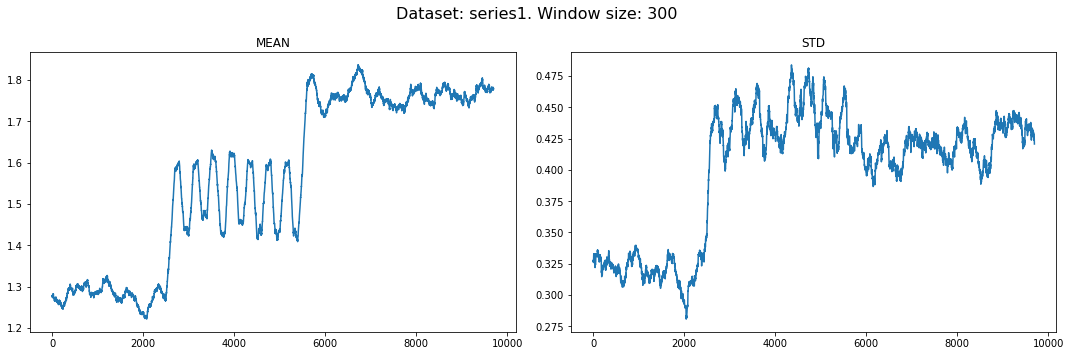

In [306]:
plot_series('series1', series1, 300)

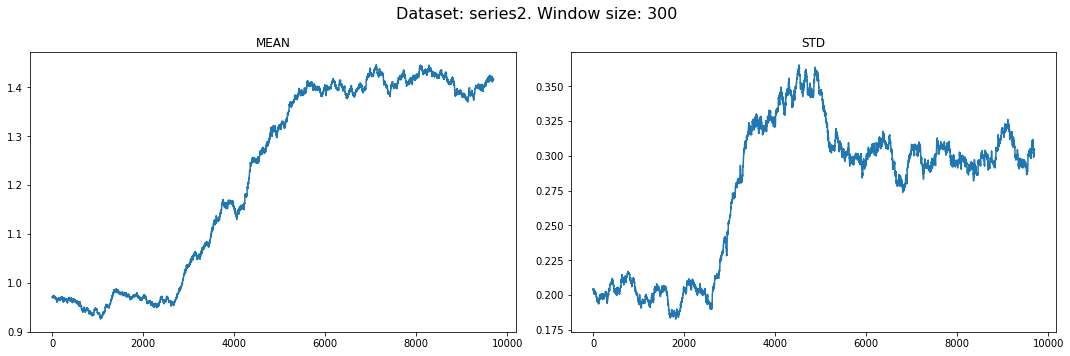

In [307]:
plot_series('series2', series2, 300)

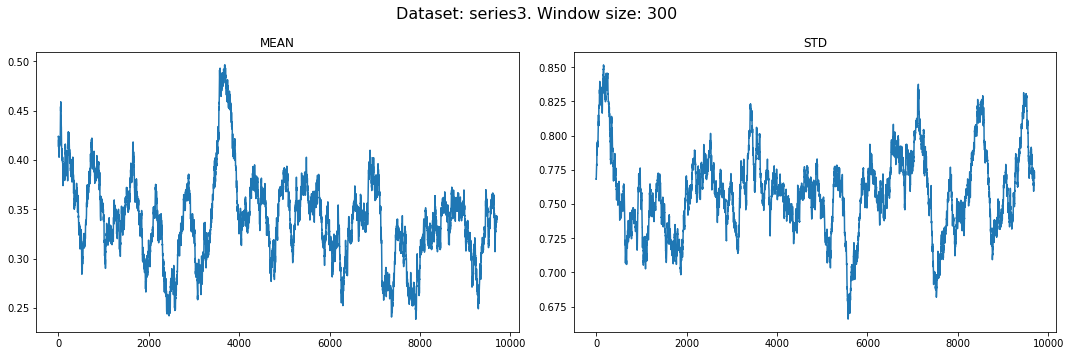

In [308]:
plot_series('series3', series3, 300)

Z pewnym rodzajem pewności i biorąc pod uwagę zmianę średniej i std w seriach czasowcyh mogę zauważyć występowanie Gradual Drift w danych ze zbioru series1, Incremental Drift - series2 oraz Recurring Drift - series3.

In [177]:
from skmultiflow.drift_detection.adwin import ADWIN


def get_changes(stream, detector):
    res = []
    for i in range(len(stream)):
        detector.add_element(stream[i])
        if detector.detected_change():
            res.append(i)
    return res


def plot_sk_results(stream_name, detector_name, stream, changes):
    plt.figure(figsize=(25,5))
    plt.title(f'Stream: {stream_name}. Detector: {detector_name}')
    plt.plot(range(len(stream)), stream)
    for c in changes:
        plt.axvline(c, color='red')

# scikit-multiflow detector - ADWIN

Do wykrywania concept driftu użyto algorytmu ADWIN z biblioteki scikit-multiflow.

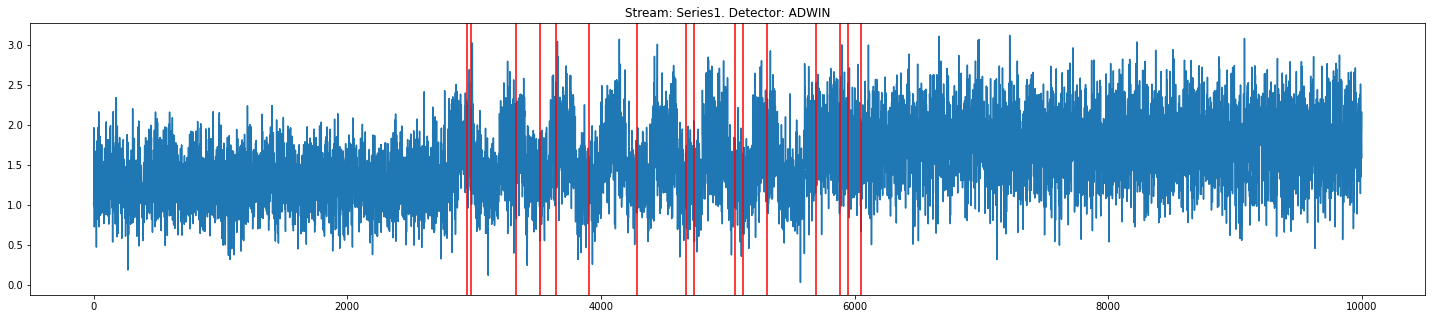

In [141]:
plot_sk_results('Series1', 'ADWIN', series1, get_changes(series1, ADWIN(delta=0.1)))

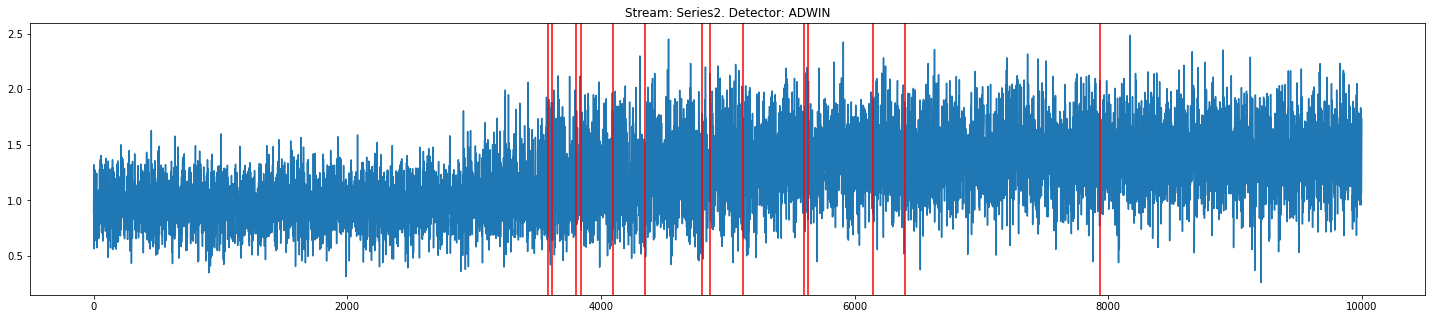

In [142]:
plot_sk_results('Series2', 'ADWIN', series2, get_changes(series2, ADWIN(delta=0.1)))

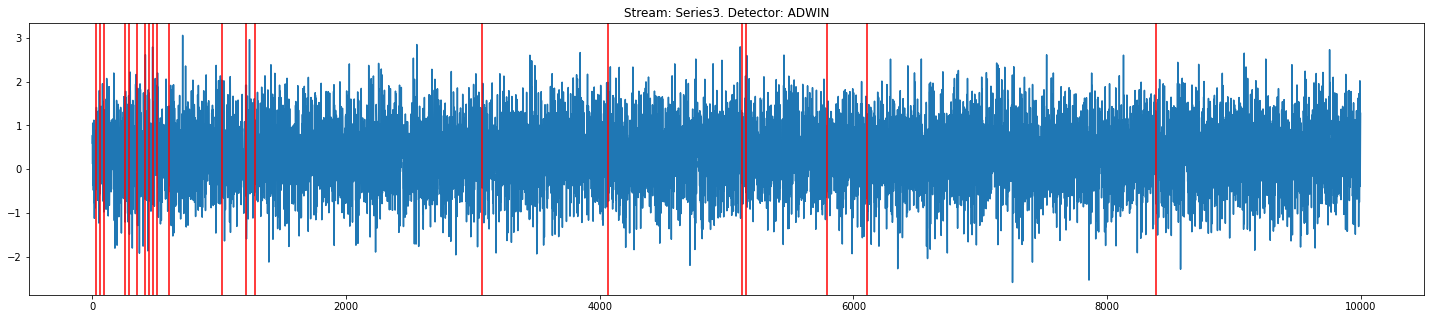

In [149]:
plot_sk_results('Series3', 'ADWIN', series3, get_changes(series3, ADWIN(delta=5)))

Nie jestem w 100 procentach pewien co do działania algorytmu, ale warto zwrócić uwagę na otrzymane wyniki. Na wykresach wyżej są przedstawione ciągi instancji z 3 zbiorów danych z pokolorowanymi na czerwono instancjami, które algorytm ADWIN wykrył za Drift. Można zauważyć, że metoda pokazuje dosyć dobre wyniki, kiedy rozkład instancji wyraźnie się zmienia. Ale mam duże wątpliwości co do wyników działania metody na 3 zbiorze. Biorąc pod wykresy mean i std nie mogę powiedzieć, że alorytm dobrze wykrył miejsca wystąpienia concept drift'u. Próbowałem dostroić parametry metod DDM oraz EDDM, ale otrzymano puste wyniki na wszystkich zbiorach.

# Manual detector

W celu wykrycia miejsca wystąpienia concept drift użyto własnej implementacji detektora.
Detektor posiada okno o stałym rozmiarze. Jest przesuwane po instancjach danej sekwencji. Po każdym takim przesunięciu jest obliczana średnia wartość lub standart deviation instancji w oknie. Także są obliczne wartości globalne. Jeśli obliczona wartość okna przekracza pewien treshold, to ostatnia instancja wczytana z sekwencji jest uznawana za miejsce w którym zaczyna się nowy rozkład. Globalnymi parametrami są threshold oraz rozmiar okna.

In [259]:
def detect_changes(sequence, threshold, window_size, detector):
    last_change_idx = []
    count = window_size

    while count < len(sequence):
        window_mean = detector(sequence[count-window_size:count])

        if last_change_idx != []:
            global_mean = detector(sequence[last_change_idx[-1]:count])
        else:
            global_mean = detector(sequence[:count])

        current_threshold = window_mean*threshold

        if np.absolute(global_mean - window_mean) > current_threshold:
            last_change_idx.append(count)
            count = count + window_size
        else:
            count += 1    
    
    return last_change_idx
    

## Mean

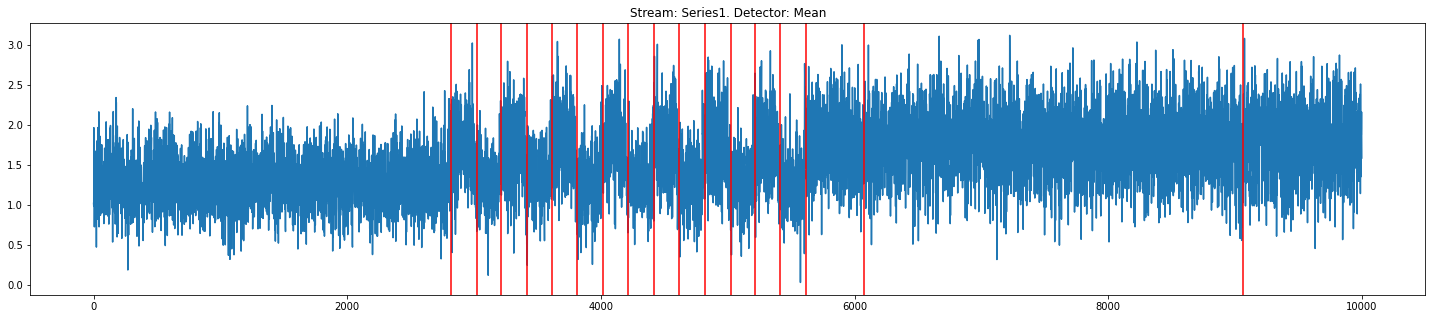

In [261]:
plot_sk_results('Series1', 'Mean', series1, detect_changes(series1, 0.15, 30, np.mean))

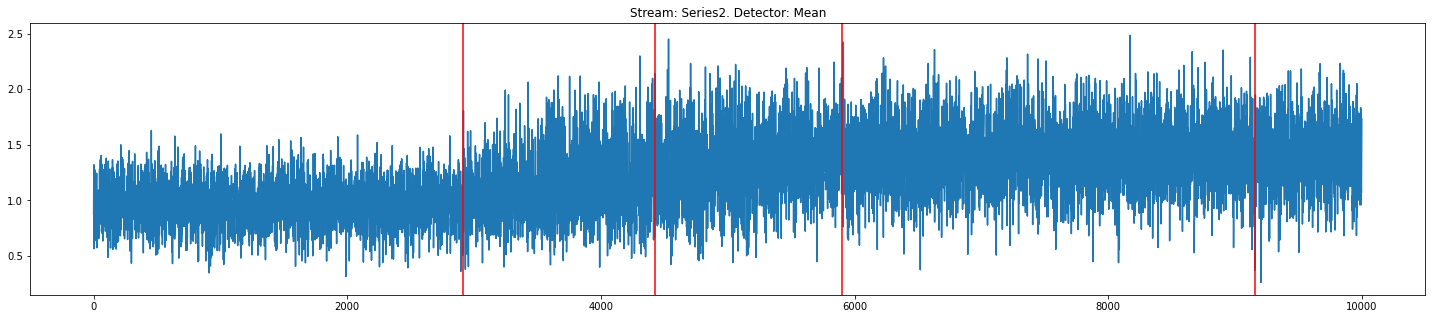

In [262]:
plot_sk_results('Series2', 'Mean', series2, detect_changes(series2, 0.15, 30, np.mean))

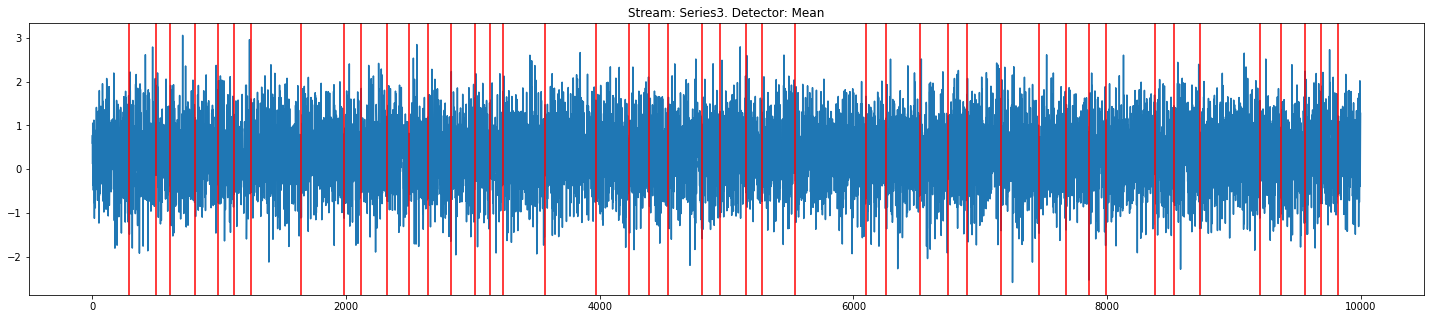

In [263]:
plot_sk_results('Series3', 'Mean', series3, detect_changes(series3, 0.2, 100, np.mean))

# Manual detector - STD

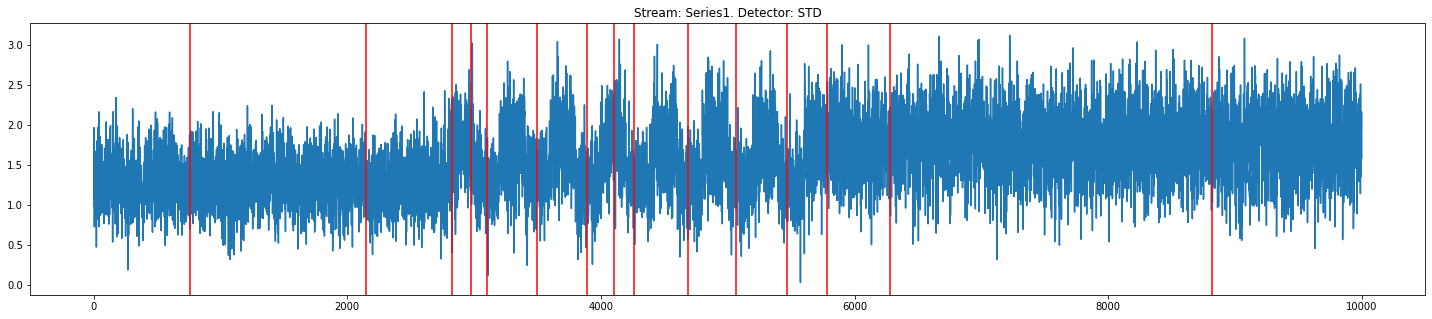

In [309]:
plot_sk_results('Series1', 'STD', series1, detect_changes(series1, 0.2, 100, np.std))

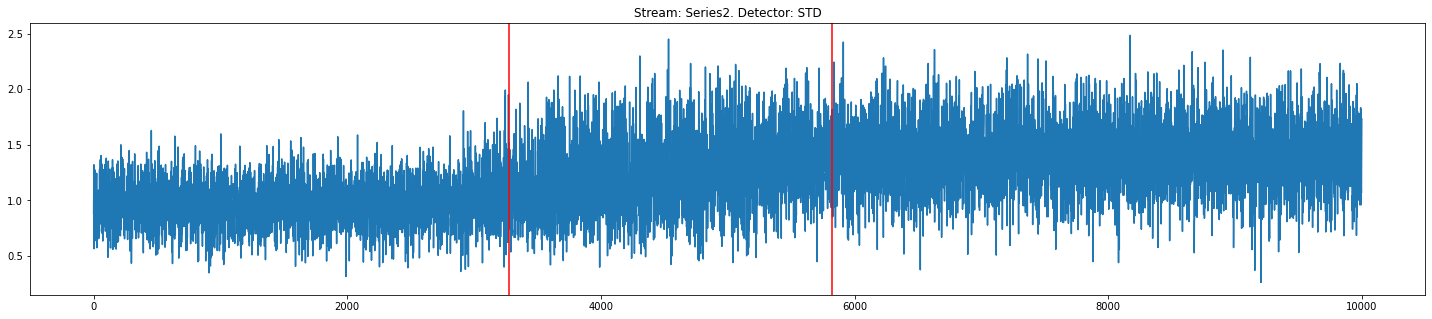

In [284]:
plot_sk_results('Series2', 'STD', series2, detect_changes(series2, 0.3, 100, np.std))

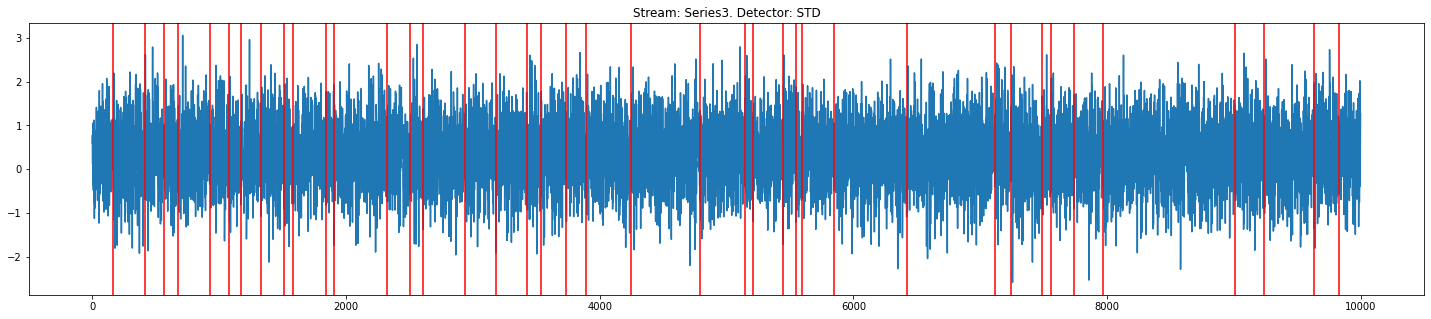

In [285]:
plot_sk_results('Series3', 'STD', series3, detect_changes(series3, 0.3, 30, np.std))

Nie istnieje jednej uniwersalnej metody wykrywania Concept Drift'u dla wszystkich rozkładów. Użyte metody znacznie lepiej działają, przy Gradual Drift (series1) oraz Incremental Drift (series2). Recurring Drift (series3) - stanowi wyzwanie, chciaż własnoręcznie zaimplementowana metoda radzi z tym ciągiem danych lepiej niż ADWIN z biblioteki scikit-multiflow. Podejście oparte na obliczniu średniej jest lepsze od std.